In [1]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [2]:
# Download Dataset (Uncomment to download)
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# !mkdir data
# !mv *.zip data/

# Unzip data
# with zipfile.ZipFile('data/train2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/val2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/annotations_trainval2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')

In [3]:
# Load annotations for training data
train_annot_path = 'data/annotations/person_keypoints_train2017.json'
val_annot_path = 'data/annotations/person_keypoints_val2017.json'
train_coco = COCO(train_annot_path) # load annotations for training set
val_coco = COCO(val_annot_path) # load annotations for validation set

loading annotations into memory...
Done (t=6.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [4]:
# Load meta data on images: https://towardsdatascience.com/how-to-analyze-the-coco-dataset-for-pose-estimation-7296e2ffb12e
def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # basic parameters of an image
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        # retrieve metadata for all persons in the current image
        anns = coco.loadAnns(ann_ids)

        yield [img_id, img_file_name, w, h, anns]
        
def convert_to_df(coco):
    images_data = []
    persons_data = []
    # iterate over all images
    for img_id, img_fname, w, h, meta in get_meta(coco):
        images_data.append({
            'image_id': int(img_id),
            'path': img_fname,
            'width': int(w),
            'height': int(h)
        })
        # iterate over all metadata
        for m in meta:
            persons_data.append({
                'image_id': m['image_id'],
                'is_crowd': m['iscrowd'],
                'bbox': m['bbox'],
                'area': m['area'],
                'num_keypoints': m['num_keypoints'],
                'keypoints': m['keypoints'],
            })
    # create dataframe with image paths
    images_df = pd.DataFrame(images_data)
    images_df.set_index('image_id', inplace=True)
    # create dataframe with persons
    persons_df = pd.DataFrame(persons_data)
    persons_df.set_index('image_id', inplace=True)
    return images_df, persons_df

# Create train and validation dfs
images_df, persons_df = convert_to_df(train_coco)
train_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

images_df, persons_df = convert_to_df(val_coco)
val_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

In [5]:
val_coco_df

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints
image_id,,,,,,,,
139,000000000139.jpg,640,426,0,"[412.8, 157.61, 53.05, 138.01]",2913.11040,15,"[427, 170, 1, 429, 169, 2, 0, 0, 0, 434, 168, ..."
139,000000000139.jpg,640,426,0,"[384.43, 172.21, 15.12, 35.74]",435.14495,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
785,000000000785.jpg,640,425,0,"[280.79, 44.73, 218.7, 346.68]",27789.11055,17,"[367, 81, 2, 374, 73, 2, 360, 75, 2, 386, 78, ..."
872,000000000872.jpg,621,640,0,"[145.26, 100.67, 291.95, 457.35]",25759.04240,12,"[367, 138, 2, 0, 0, 0, 360, 134, 2, 0, 0, 0, 3..."
872,000000000872.jpg,621,640,0,"[163.73, 126.42, 265.69, 480.4]",48091.75195,15,"[211, 187, 1, 215, 179, 2, 0, 0, 0, 241, 175, ..."
...,...,...,...,...,...,...,...,...
581357,000000581357.jpg,612,612,0,"[180.89, 440.51, 21.1, 38.36]",371.49395,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[249.22, 419.65, 13.2, 24.53]",169.55635,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[211.18, 420.26, 23.38, 40.03]",542.16740,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
# Drop all photos with no keypoints or where a group is just marked as crowd
train_coco_df = train_coco_df[train_coco_df['is_crowd']==0]
train_coco_df = train_coco_df[train_coco_df['num_keypoints']>0]

val_coco_df = val_coco_df[val_coco_df['is_crowd']==0]
val_coco_df = val_coco_df[val_coco_df['num_keypoints']>0]

In [7]:
# Takes in a dataframe and index and outputs a figure of it with keypoints at default dimensions
def displayImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = coco_df.iloc[index]["bbox"]
    keypoints = coco_df.iloc[index]["keypoints"]

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        ax.plot(keypoints[i-2], keypoints[i-1], marker='x', color="red")

    # Show bbox
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [8]:
# Takes in a dataframe and index and outputs a figure of it cropped to 224x224 with keypoints moved
def displayCroppedImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = np.array(coco_df.iloc[index]["bbox"]).astype(np.int64)
    keypoints = coco_df.iloc[index]["keypoints"]
    
    # Crop image
    img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    
    x_scale = 224/img.shape[1]
    y_scale = 224/img.shape[0]
    
    # Scale image
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        x = (keypoints[i-2] - bbox[0]) * x_scale * 1/224
        y = (keypoints[i-1] - bbox[1]) * y_scale * 1/224
        if x < 0: x = 0
        if y < 0: y = 0
            
        ax.plot(x*224, y*224, marker='x', color="red")

    plt.show()

In [56]:
kp_names = [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", 
    "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

kp_dict = {name:i*2 for i, name in enumerate(kp_names)}
print(kp_dict)

# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        if(i > 1 and i < 10): 
            continue
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        colors = ['red', 'blue', 'magenta', 'lime', 'orange', 'purple', 'pink', 'yellow', 'aqua', 'fuchsia', 'azure', 'lavender', 'magenta', 'white', 'sienna', 'indigo', 'coral']
        #ax.plot(x, y, marker='x', color=colors[i//2])
        ax.plot(x, y, marker='o', color='black')

    # draw skeleton
    left_arm = ["left_shoulder", "left_elbow", "left_wrist"]
    right_arm = ["right_shoulder", "right_elbow", "right_wrist"]
    left_leg = ["left_hip", "left_knee", "left_ankle"]
    right_leg = ["right_hip", "right_knee", "right_ankle"]

    bones = [left_arm, right_arm, left_leg, right_leg]
    colors = ['red', 'blue', 'green', 'yellow']

    for i, bone in enumerate(bones):
        x_l = []
        y_l = []
        for keypoint in bone:
            idx = kp_dict[keypoint]
            x = keypoints[idx]*w + w/2
            y = keypoints[idx+1]*h + h/2
            if x < 0 or y < 0: continue
            x_l.append(x)
            y_l.append(y)
        
        ax.plot(x_l, y_l, color=colors[i], linewidth=2)
        print(x_l)
        print(y_l)
    
    # torso:
    torso_upper_x = (keypoints[kp_dict["left_shoulder"]] + keypoints[kp_dict["right_shoulder"]])/2 * w + w/2
    torso_upper_y = (keypoints[kp_dict["left_shoulder"]+1] + keypoints[kp_dict["right_shoulder"]+1])/2 * h + h/2
    torso_lower_x = (keypoints[kp_dict["left_hip"]] + keypoints[kp_dict["right_hip"]])/2 * w + w/2
    torso_lower_y = (keypoints[kp_dict["left_hip"]+1] + keypoints[kp_dict["right_hip"]+1])/2 * h + h/2
    torso_x = [torso_upper_x, torso_lower_x]
    torso_y = [torso_upper_y, torso_lower_y]
    if(all(v >= 0 for v in torso_x) and all(v >= 0 for v in torso_y)):
        ax.plot(torso_x, torso_y, color='magenta', linewidth=2)

    # connectors 
    face_c_x = [torso_upper_x, keypoints[kp_dict["nose"]]*w + w/2]
    face_c_y = [torso_upper_y, keypoints[kp_dict["nose"]+1]*h + h/2]
    if(all(v >= 0 for v in face_c_x) and all(v >= 0 for v in face_c_y)):
        ax.plot(face_c_x, face_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["left_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["left_shoulder"]+1]*h + h/2]
    if(all(v >= 0 for v in upleft_c_x) and all(v >= 0 for v in upleft_c_y)):
        ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)
    
    upleft_c_x = [torso_upper_x, keypoints[kp_dict["right_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["right_shoulder"]+1]*h + h/2]
    if(all(v >= 0 for v in upleft_c_x) and all(v >= 0 for v in upleft_c_y)):
        ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["left_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["left_hip"]+1]*h + h/2]
    if(all(v >= 0 for v in upleft_c_x) and all(v >= 0 for v in upleft_c_y)):
        ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["right_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["right_hip"]+1]*h + h/2]
    if(all(v >= 0 for v in upleft_c_x) and all(v >= 0 for v in upleft_c_y)):
        ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    if(show):
        plt.show()
    #return np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')

{'nose': 0, 'left_eye': 2, 'right_eye': 4, 'left_ear': 6, 'right_ear': 8, 'left_shoulder': 10, 'right_shoulder': 12, 'left_elbow': 14, 'right_elbow': 16, 'left_wrist': 18, 'right_wrist': 20, 'left_hip': 22, 'right_hip': 24, 'left_knee': 26, 'right_knee': 28, 'left_ankle': 30, 'right_ankle': 32}


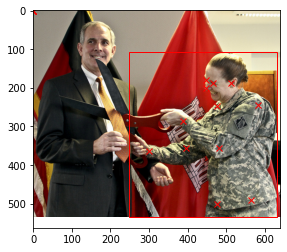

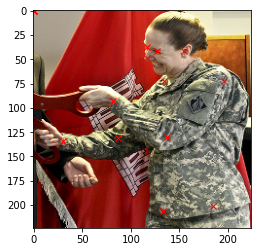

In [10]:
displayImageFromDf(train_coco_df, 21)
displayCroppedImageFromDf(train_coco_df, 21)

In [11]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [37]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data/{self.source}2017/{self.df.iloc[index]["path"]}')
        bbox = np.array(self.df.iloc[index]["bbox"]).astype(np.int64)
        keypoints = self.df.iloc[index]["keypoints"]
        
        # Account for potential gray images by adding channels
        if len(img.shape) == 2 or img.shape[2] == 1:
            if (len(img.shape) == 2): img = np.expand_dims(img,-1)
            img = cv2.merge([img,img,img])
        
        # Crop image to bbox
        img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        
        # Scale image 
        img = cv2.resize(img, dsize=(self.dimensions, self.dimensions), interpolation=cv2.INTER_CUBIC)

        bbox_tl_x = bbox[0]
        bbox_tl_y = bbox[1]
        w_original = bbox[2]
        h_original = bbox[3]

        bbox_rescale = [self.dimensions/2, self.dimensions/2, self.dimensions, self.dimensions]
        
        # Move keypoints to new bbox locations accounting for crop, scale, and normalization
        final_keypoints = []
        for i in range(2, len(keypoints), 3):
            x = (keypoints[i-2] - bbox_tl_x) * self.dimensions / w_original
            y = (keypoints[i-1] - bbox_tl_y)* self.dimensions / h_original

            x, y = N([x, y], bbox_rescale)

            v = keypoints[i]
            #print(str(x) + " " + str(y))
            
            # If resizing put keypoint outside of image then remove it
            if x < -0.5 or y < -0.5 or x > 0.5 or y > 0.5: v = 0
            
            # Set keypoints to -1 if not visible
            if v == 0:
                x = -1
                y = -1
                
            # Add final keypoints to final_keypoints
            final_keypoints.extend([x,y])
            
        img = img.astype('uint8') # enforce int 
        if self.transform: img = self.transform(img)
            
        return img, torch.FloatTensor(final_keypoints)

    def __len__(self):
        if(self.source == "train"):
            return 10000
        else:
            return 500
        return len(self.df)

[tensor(135.8452), tensor(173.4194), tensor(200.8774)]
[tensor(84.3011), tensor(159.9312), tensor(219.1828)]
[tensor(34.6839), tensor(33.2387), tensor(55.6387)]
[tensor(86.7097), tensor(172.4559), tensor(137.2903)]
[tensor(123.5613)]
[tensor(212.4387)]
[tensor(72.2581)]
[tensor(214.8473)]


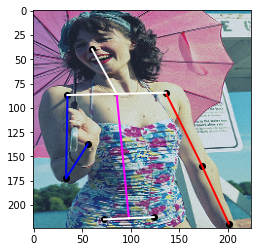

In [ ]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_coco_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=False, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [40]:

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4,4), padding=(5,5)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(96),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2,2)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),

    torch.nn.Linear(12544, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 34),
)

model = model.to(device)
model(torch.rand(32,3,224, 224).to('cuda')).shape

torch.Size([32, 34])

In [ ]:
model.load_state_dict(torch.load("model.save", map_location=device))

In [41]:
val_dataset = Coco(val_coco_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs)
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    ''''
    idx = rn.randint(0, 200)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)
    '''
    return loss 
    

check_validation_accuracy(model)

Validiation loss was 8.755168914794922


tensor(8.7552, device='cuda:0')

In [88]:
# TRAINING
train_dataset = Coco(train_coco_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001)#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 500

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))
    if(epoch % 50 == 0):
        torch.save(model.state_dict(), f'model-alldata/modelall_{epoch}.save')

# save model
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

Training 500 epochs. Dataset is 10000 big. Using batch size 64
157 minibatches are needed per epoch
Minibatch 1/157. Loss 0.15775936841964722
Minibatch 51/157. Loss 0.16605745255947113
Minibatch 101/157. Loss 0.14813078939914703
Minibatch 151/157. Loss 0.16709066927433014
Epoch 0/2. Loss 25.965316891670227
Validiation loss was 7.158297061920166
Minibatch 1/157. Loss 0.1574709117412567
Minibatch 51/157. Loss 0.1736098974943161
Minibatch 101/157. Loss 0.16080325841903687
Minibatch 151/157. Loss 0.17766360938549042
Epoch 1/2. Loss 26.013497099280357
Validiation loss was 7.213443279266357
Minibatch 1/157. Loss 0.15575434267520905
Minibatch 51/157. Loss 0.17094598710536957
Minibatch 101/157. Loss 0.1729448288679123
Minibatch 151/157. Loss 0.15811672806739807
Epoch 2/2. Loss 25.88985425233841
Validiation loss was 7.104326248168945
Minibatch 1/157. Loss 0.16424234211444855
Minibatch 51/157. Loss 0.15390659868717194
Minibatch 101/157. Loss 0.15449728071689606
Minibatch 151/157. Loss 0.15590940

IndexError: tuple index out of range

[tensor(110.1639), tensor(124.8525), tensor(84.4590)]
[tensor(44.3333), tensor(87.5000), tensor(116.6667)]
[tensor(51.4098), tensor(58.7541), tensor(40.3934)]
[tensor(45.5000), tensor(86.3333), tensor(121.3333)]
[tensor(113.8361), tensor(77.1148), tensor(201.9672)]
[tensor(110.8333), tensor(163.3333), tensor(193.6667)]
[tensor(66.0984), tensor(66.0984), tensor(102.8197)]
[tensor(110.8333), tensor(165.6667), tensor(217.)]
[247.56036567687988, 191.91553401947021, 130.65879821777344]
[152.29382610321045, 178.6475067138672, 115.55269020795822]
[154.01257038116455, 132.45050311088562, 105.06182676553726]
[134.69272232055664, 120.21841073036194, 111.85967844724655]
[154.76928997039795, 167.496253490448, 157.692804813385]
[144.20186185836792, 219.9810028076172, 173.7573947906494]
[169.25366687774658, 150.29335975646973, 135.9402892589569]
[169.0498571395874, 210.49195384979248, 208.79260921478271]


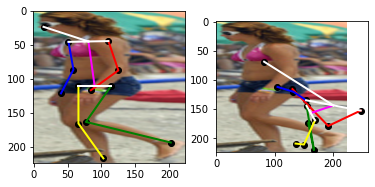

tensor([-0.1333, -0.1934, -0.0871, -0.1391, -0.0214, -0.1090,  0.0814,  0.0011,
        -0.0308, -0.2816,  0.6052,  0.1799,  0.1876,  0.1013,  0.3568,  0.2975,
         0.0913,  0.0367,  0.0833,  0.0159, -0.0310, -0.0006,  0.1909,  0.1438,
         0.2556,  0.2547,  0.2478,  0.4821,  0.1710,  0.4397,  0.2040,  0.2757,
         0.1069,  0.4321], grad_fn=<SelectBackward0>)


In [89]:
idx = rn.randint(0, 200)
img, labels =  train_dataset[idx]
a = img.numpy()
b = (a - np.min(a))/np.ptp(a)

img = img.to(device)
outputs = model(img.unsqueeze(0))
outputs = outputs.to('cpu')

fig, (ax0, ax1) = plt.subplots(1, 2)
displayImageWithKeyPoints(b, labels, ax0, False)
displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

#print(outputs[0])
#rint(b.shape)
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)